## Laboratorium 7.
#### Bartosz Hanc

#### Implementacja struktur

In [79]:
from typing import Hashable
from dataclasses import dataclass


class Tree:
    def __repr__(self) -> str:
        def rec_print(node, level=0):
            line = "" if level == 0 else "|___ "
            ret = "\t" * level + line + node.symb + "\n"

            for _, child in node.next.items():
                ret += rec_print(child, level + 1)

            return ret

        return rec_print(self.root)


# Trie - w wariancie, w którym kolejne sufiksy dodawane są przez przeszukiwanie głowy od korzenia
# drzewa
class Node:
    def __init__(self, symb):
        self.next: dict[Hashable, Node] = {}
        self.symb: str = symb


class Trie(Tree):
    def __init__(self, string):
        self.root = Node("")
        self.__build_trie(string)

    def __build_trie(self, string):
        for i in range(len(string)):
            node = self.root
            for c in string[i:]:
                if c in node.next:
                    node = node.next[c]
                else:
                    child = Node(symb=str(c))
                    node.next[c] = child
                    node = child


# Trie - w wariancie, w którym kolejne sufiksy dodawane są poprzez dodanie kolejnej litery tekstu
class LinkNode(Node):
    def __init__(self, symb, link=None):
        super().__init__(symb)
        self.link: LinkNode = self if link is None else link


class OnlineTrie(Tree):
    def __init__(self, string):
        self.root = LinkNode("")
        self.__build_trie(string)

    def __build_trie(self, string):
        root = self.root
        deepest = LinkNode(symb=string[0], link=root)
        root.next[string[0]] = deepest

        for c in string[1:]:
            curr: LinkNode = deepest
            prev: LinkNode = None

            while c not in curr.next:
                new_node = LinkNode(symb=c)
                curr.next[c] = new_node

                if prev is not None:
                    prev.link = new_node

                prev = new_node
                curr = curr.link

            if curr is root and curr.next[c] == prev:
                prev.link = root
            else:
                prev.link = curr.next[c]

            deepest = deepest.next[c]


# Drzewo sufiksów - algorytm Ukkonena
class CompressedNode:
    def __init__(self, l, r, parent=None):
        self.l: int = l
        self.r: int = r

        self.parent: CompressedNode = parent
        self.link: CompressedNode = None
        self.next: dict[str, CompressedNode] = {}

    def switch(self, ch):
        if ch in self.next:
            return self.next[ch]
        return None

    def len(self):
        return self.r - self.l


@dataclass
class State:
    node: CompressedNode
    pos: int


class CompressedTrie:
    def __init__(self, string):
        self.root = CompressedNode(0, 0)
        self.string = string
        self.__build_trie(string)

    def __repr__(self) -> str:
        def rec_print(root: CompressedNode, level=0):
            line = "" if level == 0 else "|___ "
            ret = "\t" * level + line + self.string[root.l : root.r] + "\n"

            for _, child in root.next.items():
                ret += rec_print(child, level + 1)

            return ret

        return rec_print(self.root)

    def __build_trie(self, string):
        n: int = len(string)
        root: CompressedNode = self.root
        state: State = State(root, 0)

        def traverse(st: State, l: int, r: int) -> State:
            while l < r:
                if st.pos == st.node.len():
                    st = State(st.node.switch(string[l]), 0)
                    if st.node == None:
                        return st
                else:
                    if string[st.node.l + st.pos] != string[l]:
                        return State(None, -1)
                    if r - l < st.node.len() - st.pos:
                        return State(st.node, st.pos + r - l)

                    l += st.node.len() - st.pos
                    st.pos = st.node.len()

            return st

        def split(st: State) -> CompressedNode:
            if st.pos == st.node.len():
                return st.node
            if st.pos == 0:
                return st.node.parent

            v = st.node
            new_node = CompressedNode(v.l, v.l + st.pos, v.parent)
            new_node.next[string[v.l + st.pos]] = v

            v.parent.next[string[v.l]] = new_node
            v.parent = new_node
            v.l += st.pos

            return new_node

        def suff_link(v: CompressedNode) -> CompressedNode:
            if v.link != None:
                return v.link

            if v.parent == None:
                return self.root

            u = suff_link(v.parent)
            v.link = split(
                traverse(
                    State(u, u.len()), v.l + (1 if v.parent is self.root else 0), v.r
                )
            )

            return v.link

        for pos, ch in enumerate(string):
            while True:
                new_state: State = traverse(state, pos, pos + 1)
                if new_state.node != None:
                    state = new_state
                    break

                mid = split(state)
                mid.next[ch] = CompressedNode(pos, n, mid)

                state.node = suff_link(mid)
                state.pos = state.node.len()
                if mid is root:
                    break


#### Wizualizacja struktur

In [80]:
Trie("ababcd" + "$")



	|___ a
		|___ b
			|___ a
				|___ b
					|___ c
						|___ d
							|___ $
			|___ c
				|___ d
					|___ $
	|___ b
		|___ a
			|___ b
				|___ c
					|___ d
						|___ $
		|___ c
			|___ d
				|___ $
	|___ c
		|___ d
			|___ $
	|___ d
		|___ $
	|___ $

In [81]:
OnlineTrie("ababcd" + "$")



	|___ a
		|___ b
			|___ a
				|___ b
					|___ c
						|___ d
							|___ $
			|___ c
				|___ d
					|___ $
	|___ b
		|___ a
			|___ b
				|___ c
					|___ d
						|___ $
		|___ c
			|___ d
				|___ $
	|___ c
		|___ d
			|___ $
	|___ d
		|___ $
	|___ $

In [87]:
CompressedTrie("aabbabd" + "$")



	|___ a
		|___ abbabd$
		|___ b
			|___ babd$
			|___ d$
	|___ b
		|___ babd$
		|___ abd$
		|___ d$
	|___ d$
	|___ $

In [88]:
CompressedTrie("ababcd" + "$")


	|___ ab
		|___ abcd$
		|___ cd$
	|___ b
		|___ abcd$
		|___ cd$
	|___ cd$
	|___ d$
	|___ $

In [83]:
CompressedTrie("abaababaabaabaabab" + "$")



	|___ a
		|___ b
			|___ a
				|___ aba
					|___ b
						|___ aabaabaabab$
						|___ $
					|___ aba
						|___ abab$
						|___ b$
				|___ b
					|___ aabaabaabab$
					|___ $
			|___ $
		|___ aba
			|___ b
				|___ aabaabaabab$
				|___ $
			|___ aba
				|___ abab$
				|___ b$
	|___ b
		|___ a
			|___ aba
				|___ b
					|___ aabaabaabab$
					|___ $
				|___ aba
					|___ abab$
					|___ b$
			|___ b
				|___ aabaabaabab$
				|___ $
		|___ $
	|___ $

#### Benchmark

In [84]:
import timeit

from random import choices
from string import ascii_letters
from tabulate import tabulate


END = "$"
s1 = "bbb" + END
s2 = "ababcd" + END
s3 = "aabbabd" + END
s4 = "abaababaabaabaabab" + END
s5 = "".join(choices(ascii_letters, k=100)) + END
s6 = open("1997_714_head.txt", "r").read() + END

data = []

for i, s in enumerate([s1, s2, s3, s4, s5, s6]):
    data.append(["s" + str(i + 1), len(s)])
    for tree in (Trie, OnlineTrie, CompressedTrie):
        t = timeit.timeit(lambda: tree(s), number=10) / 10
        data[i].append("{:.3e}".format(t) + "s")

print(
    tabulate(
        data,
        headers=["String", "Length", "Trie", "OnlineTrie", "CompressedTrie"],
        tablefmt="rounded_grid",
    )
)


╭──────────┬──────────┬────────────┬──────────────┬──────────────────╮
│ String   │   Length │ Trie       │ OnlineTrie   │ CompressedTrie   │
├──────────┼──────────┼────────────┼──────────────┼──────────────────┤
│ s1       │        4 │ 1.083e-05s │ 2.387e-05s   │ 1.567e-05s       │
├──────────┼──────────┼────────────┼──────────────┼──────────────────┤
│ s2       │        7 │ 2.719e-05s │ 1.586e-05s   │ 1.919e-05s       │
├──────────┼──────────┼────────────┼──────────────┼──────────────────┤
│ s3       │        8 │ 1.313e-05s │ 1.751e-05s   │ 2.345e-05s       │
├──────────┼──────────┼────────────┼──────────────┼──────────────────┤
│ s4       │       19 │ 4.784e-05s │ 8.912e-05s   │ 6.872e-05s       │
├──────────┼──────────┼────────────┼──────────────┼──────────────────┤
│ s5       │      101 │ 2.288e-03s │ 3.243e-03s   │ 2.252e-04s       │
├──────────┼──────────┼────────────┼──────────────┼──────────────────┤
│ s6       │     2539 │ 1.559e+00s │ 1.875e+00s   │ 8.976e-03s       │
╰─────

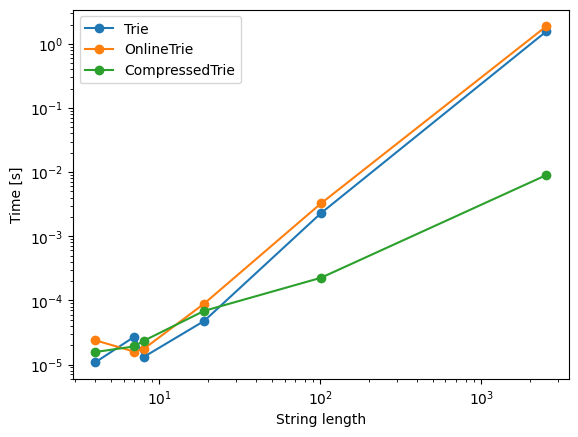

In [85]:
import matplotlib.pyplot as plt

dataT = [
    [float(data[j][i][:-1]) for j in range(len(data))] for i in range(2, len(data[0]))
]
dataT.append([data[i][1] for i in range(len(data))])
dataT

fig, ax = plt.subplots()

ax.plot(dataT[-1], dataT[0], label="Trie", marker="o")
ax.plot(dataT[-1], dataT[1], label="OnlineTrie", marker="o")
ax.plot(dataT[-1], dataT[2], label="CompressedTrie", marker="o")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("String length")
ax.set_ylabel("Time [s]")
ax.legend(loc="best")
